In [ ]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [ ]:
path = r'/content/nietzsche.txt'
text = open(path, encoding='utf-8').read().lower()
print('corpus length:', len(text))

corpus length: 600893


In [ ]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 57


In [ ]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 200285


In [ ]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
sentences[100]

've been unskilled and unseemly methods f'

In [ ]:
next_chars[100]

'o'

In [ ]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
X.shape

(200285, 40, 57)

In [ ]:
y.shape

(200285, 57)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [ ]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
1487/1487 [==============================] - 27s 14ms/step - loss: 1.9849 - accuracy: 0.4186 - val_loss: 1.6772 - val_accuracy: 0.4993
Epoch 2/20
1487/1487 [==============================] - 19s 13ms/step - loss: 1.6319 - accuracy: 0.5149 - val_loss: 1.5714 - val_accuracy: 0.5286
Epoch 3/20
1487/1487 [==============================] - 19s 12ms/step - loss: 1.5398 - accuracy: 0.5409 - val_loss: 1.5381 - val_accuracy: 0.5348
Epoch 4/20
1487/1487 [==============================] - 19s 13ms/step - loss: 1.4930 - accuracy: 0.5527 - val_loss: 1.5179 - val_accuracy: 0.5455
Epoch 5/20
1487/1487 [==============================] - 19s 13ms/step - loss: 1.4621 - accuracy: 0.5610 - val_loss: 1.5086 - val_accuracy: 0.5528
Epoch 6/20
1487/1487 [==============================] - 18s 12ms/step - loss: 1.4365 - accuracy: 0.5669 - val_loss: 1.5088 - val_accuracy: 0.5463
Epoch 7/20
1487/1487 [==============================] - 18s 12ms/step - loss: 1.4203 - accuracy: 0.5715 - val_loss: 1.4835 -

In [ ]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [ ]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

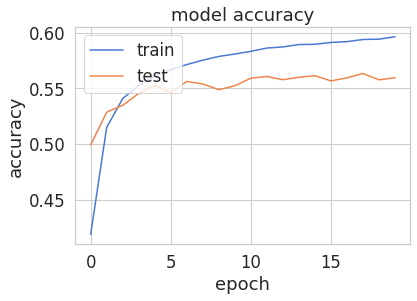

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

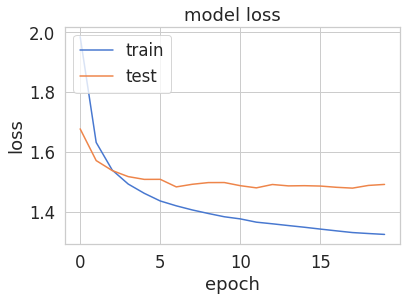

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [ ]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [ ]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'an ', 'conscience ', 'man ', 'philosophers ']

that which does not kill us makes us str
['ong ', 'ength ', 'ive ', 'ange ', 'ugg ']

i'm not upset that you lied to me, i'm u
['seful ', 'nconditional ', 'pon ', 'ltimate ', 'ttely ']

and those who were seen dancing were tho
['ught ', 'se ', 'rough ', 'o ', 'nounes, ']

it is hard enough to remember my opinion
[' of ', ', ', 's ', '. ', '\nof ']

